In [1]:
import os
import glob
import folium
import requests
import numpy as np 
import pandas as pd
import seaborn as sns
import json, requests

from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.express as ex
from datetime import date, timedelta
from sklearn.cluster import KMeans
from statsmodels.tsa.arima_model import ARIMA

from datetime import datetime 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objs as go
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.dates as mdates
from IPython.display import Markdown
from datetime import timedelta

from plotly.offline import init_notebook_mode, iplot 
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
from folium import plugins
plt.style.use("seaborn-talk")
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'
from fbprophet import Prophet
pd.set_option('display.max_rows', None)

Symptoms and % obtained from wiki : https://en.wikipedia.org/wiki/Coronavirus_disease_2019

COVID19 Current data from Family of Health and welfare site : https://www.mohfw.gov.in

In [2]:
for directory, _, files in os.walk('/input/india'):
    for file in files:
        print(os.path.join(directory, file))

/input/india\AgeGroupDetails.csv
/input/india\complete.csv
/input/india\covid_19_india.csv
/input/india\HospitalBedsIndia.csv
/input/india\ICMRTestingDetails.csv
/input/india\IndividualDetails.csv
/input/india\population_india_census2011.csv


In [3]:
#dictionary of symptoms with its percentage value
symptoms = {'symptom':['Fever',
        'Dry cough',
        'Fatigue',
        'Sputum production',
        'Shortness of breath',
        'Muscle or joint pain',
        'Sore throat',
        'Headache',
        'Chills',
        'Nausea or vomiting',
        'Nasal congestion',
        'Diarrhoea',
        'Haemoptysis',
        'Conjunctival congestion'],'percentage':[87.9,67.7,38.1,33.4,18.6,14.8,13.9,13.6,11.4,5.0,4.8,3.7,0.9,0.8]}
symptoms = pd.DataFrame(data=symptoms,index=range(14))

In [4]:
fig = px.bar(symptoms[['symptom', 'percentage']].sort_values('percentage', ascending=False), 
             y="percentage", x="symptom", color='symptom', 
             log_y=True, template='ggplot2', title='Statistics for Confirmed Cases')
fig.show()

In [5]:
#path to find the cleaned global data csv file
covid_global_cleaned_data = pd.read_csv("../input/world/covid_19_clean_complete.csv")
covid_global_cleaned_data.tail()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
18427,NaN,MS Zaandam,0.000000,0.000000,4/2/20,9,2,0
18428,NaN,Botswana,-22.328500,24.684900,4/2/20,4,1,0
18429,NaN,Burundi,-3.373100,29.918900,4/2/20,3,0,0
18430,NaN,Sierra Leone,8.460555,-11.779889,4/2/20,2,0,0
18431,NaN,Malawi,-13.254308,34.301525,4/2/20,3,0,0


In [6]:
#sum of null values in each column
covid_global_cleaned_data.isna().sum()

Province/State    12816
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

In [7]:
#displaying records as per latest date available
updates_covid19 = covid_global_cleaned_data.sort_values(['Date','Country/Region','Province/State'])
newest_first = covid_global_cleaned_data[covid_global_cleaned_data.Date == updates_covid19.Date.max()]
newest_first.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
18176,NaN,Afghanistan,33.0000,65.0000,4/2/20,273,6,10
18177,NaN,Albania,41.1533,20.1683,4/2/20,277,16,76
18178,NaN,Algeria,28.0339,1.6596,4/2/20,986,86,61
18179,NaN,Andorra,42.5063,1.5218,4/2/20,428,15,10
18180,NaN,Angola,-11.2027,17.8739,4/2/20,8,2,1


In [8]:
new_data = newest_first.rename(columns={ "Country/Region": "Country", "Province/State": "State", "Confirmed":"Confirm", "Deaths": "Death","Recovered":"Recover"})
new_data.head()

,State,Country,Lat,Long,Date,Confirm,Death,Recover
18176,NaN,Afghanistan,33.0000,65.0000,4/2/20,273,6,10
18177,NaN,Albania,41.1533,20.1683,4/2/20,277,16,76
18178,NaN,Algeria,28.0339,1.6596,4/2/20,986,86,61
18179,NaN,Andorra,42.5063,1.5218,4/2/20,428,15,10
18180,NaN,Angola,-11.2027,17.8739,4/2/20,8,2,1


In [9]:
#taking the statistics of people affected by COVID19
new_data1 = new_data.groupby("Country")[['Confirm', 'Death', 'Recover']].sum().reset_index()
new_data1.head()

,Country,Confirm,Death,Recover
0,Afghanistan,273,6,10
1,Albania,277,16,76
2,Algeria,986,86,61
3,Andorra,428,15,10
4,Angola,8,2,1


In [10]:
#worldmap view to see the countries and their affected states
world_map = folium.Map(location=[32.4279,53.6880 ], zoom_start=4, tiles='Stamen Terrain')

for Lat, Long, state in zip(new_data['Lat'], new_data['Long'], new_data['State']):
    folium.CircleMarker([Lat, Long], radius=5, color='red', 
                        popup =('State: ' + str(state) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(world_map)

world_map

In [11]:
fig = px.bar(new_data[['Country', 'Confirm']].sort_values('Confirm', ascending=False), 
             y="Confirm", x="Country", color='Country', 
             log_y=True, template='ggplot2', title='Statistics for Confirmed Cases')
fig.show()

### **Cases in India as per global data** ###

In [12]:
#mostly affected age group as per global data
gloabl_age = pd.read_csv("../input/world/COVID19_open_line_list.csv")
gloabl_age = gloabl_age.groupby(["country","age"])

global_age = gloabl_age.first()

In [13]:
global_age.head()

ID     sex        city         province  \
country     age                                                   
Afghanistan 35     12094.0    male         NaN            Herat   
Australia   20-29   4876.0  female   Melbourne         Victoria   
            21      1086.0  female      Sydney  New South Wales   
            35       673.0    male      Sydney  New South Wales   
            37      6587.0  female  Gold Coast       Queensland   

                   wuhan(0)_not_wuhan(1)   latitude   longitude  \
country     age                                                   
Afghanistan 35                       1.0  34.341944   62.203056   
Australia   20-29                    1.0 -37.813600  144.963100   
            21                       1.0 -32.238340  147.004500   
            35                       1.0 -32.238340  147.004500   
            37                       1.0 -28.016700  153.400000   

                  geo_resolution date_onset_symptoms date_admission_hospital  \
country     age                                                                
Afghanistan 35            admin1                 NaN                     NaN   
Australia   20-29          point          27.01.2020              30.01.2020   
            21            admin1                 NaN                     NaN   
            35            admin1          15.01.2020              15.01.2020   
            37             point                 NaN                     NaN   

                   ... Unnamed: 35 Unnamed: 36 Unnamed: 37 Unnamed: 38  \
country     age    ...                                                   
Afghanistan 35     ...         NaN         NaN         NaN         NaN   
Australia   20-29  ...         NaN         NaN         NaN         NaN   
            21     ...         NaN         NaN         NaN         NaN   
            35     ...         NaN         NaN         NaN         NaN   
            37     ...         NaN         NaN         NaN         NaN   

                  Unnamed: 39 Unnamed: 40 Unnamed: 41  Unnamed: 42  \
country     age                                                      
Afghanistan 35            NaN         NaN         NaN          NaN   
Australia   20-29         NaN         NaN         NaN          NaN   
            21            NaN         NaN         NaN          NaN   
            35            NaN         NaN         NaN          NaN   
            37            NaN         NaN         NaN          NaN   

                  Unnamed: 43 Unnamed: 44  
country     age                            
Afghanistan 35            NaN         NaN  
Australia   20-29         NaN         NaN  
            21            NaN         NaN  
            35            NaN         NaN  
            37            NaN         NaN  

[5 rows x 43 columns]

In [15]:
#data related to India
gloabl_covid_india = covid_global_cleaned_data[covid_global_cleaned_data['Country/Region']=='India']
global_data_india = gloabl_covid_india.tail(22)
global_data_india.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
12931,NaN,India,21.0,78.0,3/12/20,73,1,4
13187,NaN,India,21.0,78.0,3/13/20,82,2,4
13443,NaN,India,21.0,78.0,3/14/20,102,2,4
13699,NaN,India,21.0,78.0,3/15/20,113,2,13
13955,NaN,India,21.0,78.0,3/16/20,119,2,13


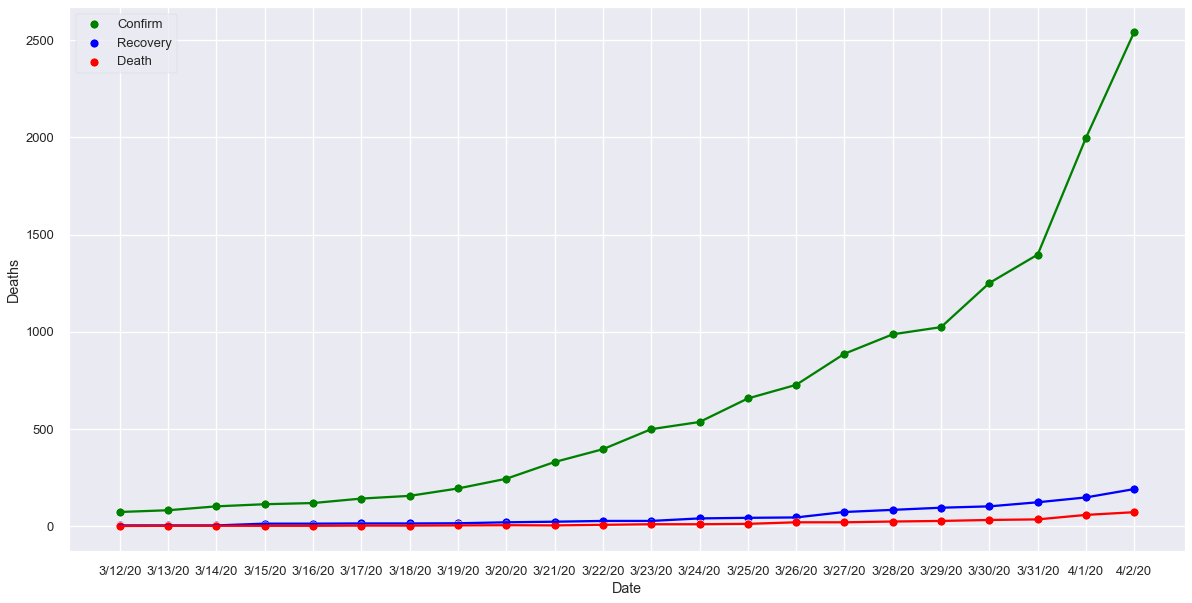

In [23]:
f, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x="Date", y="Confirmed", data=global_data_india,
             color="green", label = "Confirm")
ax = sns.scatterplot(x="Date", y="Recovered", data=global_data_india,
             color="blue", label = "Recovery")
ax = sns.scatterplot(x="Date", y="Deaths", data=global_data_india,
             color="red", label = "Death")
plt.plot(global_data_india.Date, global_data_india.Confirmed, zorder=1, color="green")
plt.plot(global_data_india.Date, global_data_india.Recovered, zorder=1, color="blue")
plt.plot(global_data_india.Date, global_data_india.Deaths, zorder=1, color="red")

In [17]:
global_uncleaned_data = pd.read_csv("../input/world/covid_19_data.csv")

In [18]:
#function to smooth data to find growth of COVID19
def smoother(inputdata,w,imax):
    data = 1.0*inputdata
    data = data.replace(np.nan,1)
    data = data.replace(np.inf,1)
    #print(data)
    smoothed = 1.0*data
    normalization = 1
    for i in range(-imax,imax+1):
        if i==0:
            continue
        smoothed += (w**abs(i))*data.shift(i,axis=0)
        normalization += w**abs(i)
    smoothed /= normalization
    return smoothed

In [19]:
global_uncleaned_data = global_uncleaned_data.rename(columns={"ObservationDate": "Date"})

In [28]:
#function to plot the active, confirmed, recovered cases and deaths in the given country
def plot_country_statistics(country):
    
    # Plots Active, Confirmed, and Recovered Cases. Also plots deaths.
    country_data = global_uncleaned_data[global_uncleaned_data['Country/Region']==country]
    table = country_data.drop(['SNo','Province/State', 'Last Update'], axis=1)
    table['ActiveCases'] = table['Confirmed'] - table['Recovered'] - table['Deaths']
    table2 = pd.pivot_table(table, values=['ActiveCases','Confirmed', 'Recovered','Deaths'], index=['Date'], aggfunc=np.sum)
    table3 = table2.drop(['Deaths'], axis=1)
   
    #Plot the growth rate, we will define this as k in the logistic function presented at the beginning of this notebook.
    table2['GrowthRate']=np.gradient(np.log(table2['Confirmed']))
    table2['GrowthRate'] = smoother(table2['GrowthRate'],0.5,3)
    
    # horizontal line at growth rate 1.0 for reference
    x_coordinates = [1, 100]
    y_coordinates = [1, 1]
    #plots
    table2['Deaths'].plot(title='Deaths', figsize=(10,5))
    plt.show()
    table3.plot(title='Statistics of cases in '+country, figsize=(10,5)) 
    plt.show()
    table2['GrowthRate'].plot(title='Growth Rate', figsize=(10,5))
    plt.show()

    return 

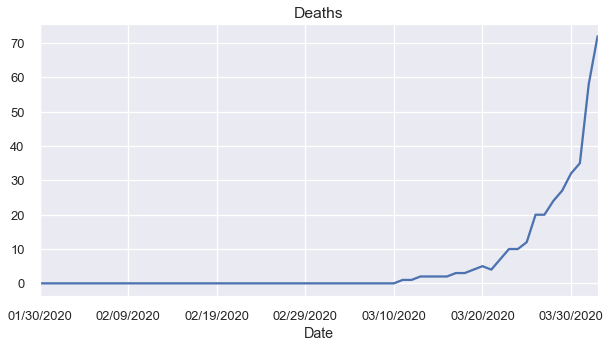

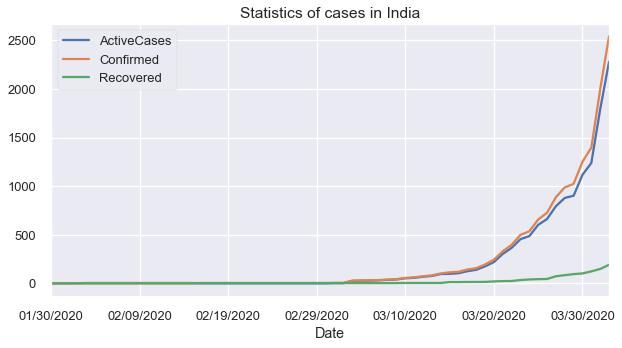

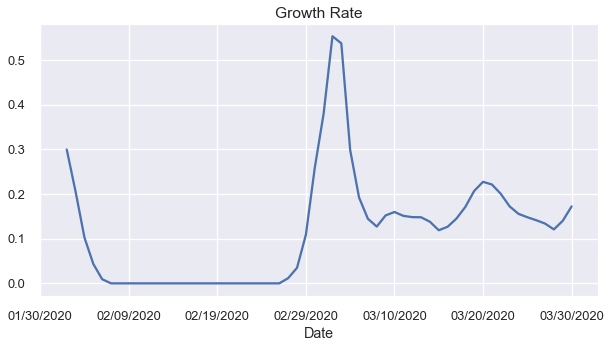

In [29]:
plot_country_statistics('India')

### **Precdiction as per Global data** ###

**Number of cases to be confirmed**

In [30]:
prophet_confirm = gloabl_covid_india.iloc[: , [4,5 ]].copy() 
prophet_confirm.columns = ['ds','y']
prophet_confirm.head()

,ds,y
131,1/22/20,0
387,1/23/20,0
643,1/24/20,0
899,1/25/20,0
1155,1/26/20,0


In [31]:
#prophet to predict the trend
confirm_trend_prophet = Prophet()
confirm_trend_prophet.fit(prophet_confirm)
future_confirm = confirm_trend_prophet.make_future_dataframe(periods=15)
forecast_confirm = confirm_trend_prophet.predict(future_confirm)
forecast_confirm

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Akhil Harry\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-33.323774,-177.270473,161.858947,-33.323774,-33.323774,35.940336,35.940336,35.940336,35.940336,35.940336,35.940336,0.0,0.0,0.0,2.616562
1,2020-01-23,-31.728063,-131.299463,203.212505,-31.728063,-31.728063,67.656754,67.656754,67.656754,67.656754,67.656754,67.656754,0.0,0.0,0.0,35.928691
2,2020-01-24,-30.132352,-210.423442,119.881263,-30.132352,-30.132352,-18.741531,-18.741531,-18.741531,-18.741531,-18.741531,-18.741531,0.0,0.0,0.0,-48.873882
3,2020-01-25,-28.536641,-219.816351,123.960793,-28.536641,-28.536641,-19.686893,-19.686893,-19.686893,-19.686893,-19.686893,-19.686893,0.0,0.0,0.0,-48.223534
4,2020-01-26,-26.940930,-216.808850,127.594795,-26.940930,-26.940930,-29.737613,-29.737613,-29.737613,-29.737613,-29.737613,-29.737613,0.0,0.0,0.0,-56.678542
5,2020-01-27,-25.345219,-212.708087,126.667770,-25.345219,-25.345219,-17.488356,-17.488356,-17.488356,-17.488356,-17.488356,-17.488356,0.0,0.0,0.0,-42.833575
6,2020-01-28,-23.749508,-213.976148,121.009887,-23.749508,-23.749508,-17.942697,-17.942697,-17.942697,-17.942697,-17.942697,-17.942697,0.0,0.0,0.0,-41.692205
7,2020-01-29,-22.153797,-159.257910,178.823062,-22.153797,-22.153797,35.940336,35.940336,35.940336,35.940336,35.940336,35.940336,0.0,0.0,0.0,13.786539
8,2020-01-30,-20.558086,-115.886001,209.604991,-20.558086,-20.558086,67.656754,67.656754,67.656754,67.656754,67.656754,67.656754,0.0,0.0,0.0,47.098667
9,2020-01-31,-18.962375,-211.751665,127.102555,-18.962375,-18.962375,-18.741531,-18.741531,-18.741531,-18.741531,-18.741531,-18.741531,0.0,0.0,0.0,-37.703906


In [32]:
confirm_predicted = forecast_confirm.loc[:,['ds','trend']]
confirm_predicted = confirm_predicted[confirm_predicted['trend']>0]
confirm_predicted = confirm_predicted.tail(15)
confirm_predicted.columns = ['Date','Confirm']
confirm_predicted.head()

,Date,Confirm
72,2020-04-03,1709.525226
73,2020-04-04,1809.230183
74,2020-04-05,1908.935140
75,2020-04-06,2008.640097
76,2020-04-07,2108.345054


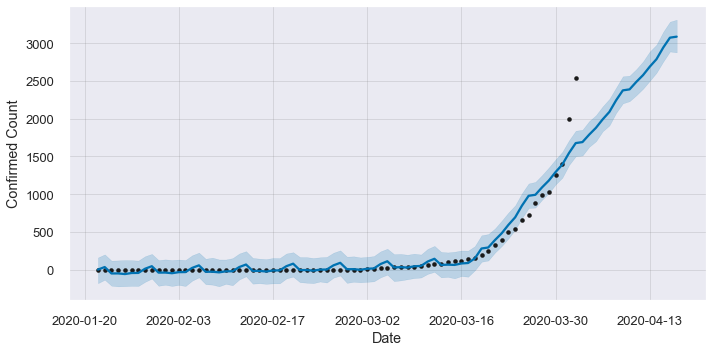

In [36]:
##actual and predicted values plot
figure_confirm = plot_plotly(confirm_trend_prophet, forecast_confirm)
py.iplot(figure_confirm) 
figure = confirm_trend_prophet.plot(forecast_confirm, xlabel='Date', ylabel='Confirmed Count', figsize=(10,5))

From the above plot, we can clearly see that the number of cases on today's date is 2543, which would have been avoided if people had followed proper lockdowns. The prediction for today's date shows that the number of cases would have been 1690, had if people followed rules. There are many assumptions for this actual rise. Some of them are as follows:
1. People breaking lockdown rules
2. Delhi tablighi jamaat meeting
3. Bringing COVID affected Indian people from various parts of the world
4. Internal community spreads

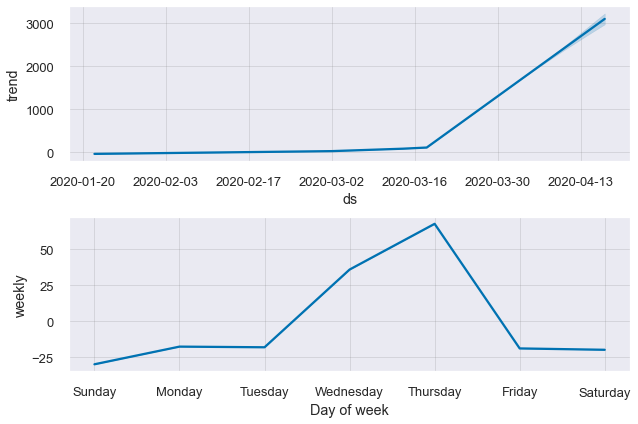

In [37]:
figure = confirm_trend_prophet.plot_components(forecast_confirm)

**Number of cases about Deaths**

In [38]:
prophet_death = gloabl_covid_india.iloc[: , [4,6 ]].copy() 
prophet_death.columns = ['ds','y']
prophet_death.head()

,ds,y
131,1/22/20,0
387,1/23/20,0
643,1/24/20,0
899,1/25/20,0
1155,1/26/20,0


In [39]:
#prophet to predict the trend
death_trend_prophet = Prophet()
death_trend_prophet.fit(prophet_death)
future_death = death_trend_prophet.make_future_dataframe(periods=15)
forecast_death = death_trend_prophet.predict(future_death)
forecast_death

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Akhil Harry\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-1.985844,-9.868776,8.629470,-1.985844,-1.985844,1.472224,1.472224,1.472224,1.472224,1.472224,1.472224,0.0,0.0,0.0,-0.513620
1,2020-01-23,-1.918815,-7.817915,9.662041,-1.918815,-1.918815,3.104591,3.104591,3.104591,3.104591,3.104591,3.104591,0.0,0.0,0.0,1.185776
2,2020-01-24,-1.851786,-11.723042,6.509384,-1.851786,-1.851786,-1.113428,-1.113428,-1.113428,-1.113428,-1.113428,-1.113428,0.0,0.0,0.0,-2.965214
3,2020-01-25,-1.784757,-11.820701,6.107651,-1.784757,-1.784757,-1.203505,-1.203505,-1.203505,-1.203505,-1.203505,-1.203505,0.0,0.0,0.0,-2.988261
4,2020-01-26,-1.717728,-12.034824,5.875581,-1.717728,-1.717728,-0.993852,-0.993852,-0.993852,-0.993852,-0.993852,-0.993852,0.0,0.0,0.0,-2.711580
5,2020-01-27,-1.650699,-11.873748,7.354282,-1.650699,-1.650699,-0.584231,-0.584231,-0.584231,-0.584231,-0.584231,-0.584231,0.0,0.0,0.0,-2.234929
6,2020-01-28,-1.583670,-11.180134,6.599646,-1.583670,-1.583670,-0.681800,-0.681800,-0.681800,-0.681800,-0.681800,-0.681800,0.0,0.0,0.0,-2.265469
7,2020-01-29,-1.516641,-8.512153,9.246257,-1.516641,-1.516641,1.472224,1.472224,1.472224,1.472224,1.472224,1.472224,0.0,0.0,0.0,-0.044416
8,2020-01-30,-1.449612,-7.765874,10.545710,-1.449612,-1.449612,3.104591,3.104591,3.104591,3.104591,3.104591,3.104591,0.0,0.0,0.0,1.654979
9,2020-01-31,-1.382583,-11.044544,6.111202,-1.382583,-1.382583,-1.113428,-1.113428,-1.113428,-1.113428,-1.113428,-1.113428,0.0,0.0,0.0,-2.496010


In [41]:
death_predicted = forecast_death.loc[:,['ds','trend']]
death_predicted = death_predicted[death_predicted['trend']>0]
death_predicted = death_predicted.tail(15)
death_predicted.columns = ['Date','Death']
death_predicted.head()

,Date,Death
72,2020-04-03,29.752724
73,2020-04-04,30.896633
74,2020-04-05,32.040542
75,2020-04-06,33.184451
76,2020-04-07,34.328360


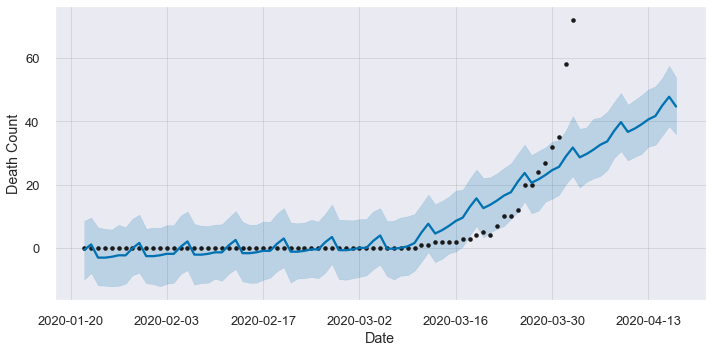

In [43]:
#actual and predicted values plot
figure_death = plot_plotly(death_trend_prophet, forecast_death)
py.iplot(figure_death) 
figure_dth = death_trend_prophet.plot(forecast_death, xlabel='Date', ylabel='Death Count', figsize=(10,5))

## **COVID19 as per Indian Govt. data** ##

In [44]:
#store data from gov site into a temporary dataframe
gov_link = 'https://www.mohfw.gov.in/'
request_to = requests.get(gov_link)
webpage_soup = BeautifulSoup(request_to.content, "html.parser")
related_thead = webpage_soup.find_all('thead')[-1]
head = related_thead.find_all('tr')
related_tbody = webpage_soup.find_all('tbody')[-1]
body = related_tbody.find_all('tr')
head_rows = []
body_rows = []
for tr in head:
    td = tr.find_all(['th', 'td'])
    row = [i.text for i in td]
    head_rows.append(row)   
for tr in body:
    td = tr.find_all(['th', 'td'])
    row = [i.text for i in td]
    body_rows.append(row)
    
temp_df = pd.DataFrame(body_rows[:len(body_rows)-1], columns=head_rows[0])   
temp_df.drop('S. No.', axis=1, inplace=True)

#set time to current pc's time
now  = datetime.now()
temp_df['Date'] = now.strftime("%m/%d/%Y") 
temp_df['Date'] = pd.to_datetime(temp_df['Date'], format='%m/%d/%Y')

In [45]:
#location values of each state, obtained from gov site
locations = {
    "Kerala" : [10.8505,76.2711],"Maharashtra" : [19.7515,75.7139],"Karnataka": [15.3173,75.7139],"Telangana": [18.1124,79.0193],
    "Uttar Pradesh": [26.8467,80.9462],"Rajasthan": [27.0238,74.2179],"Gujarat":[22.2587,71.1924],"Delhi" : [28.7041,77.1025],
    "Punjab":[31.1471,75.3412],"Tamil Nadu": [11.1271,78.6569],"Haryana": [29.0588,76.0856],"Madhya Pradesh":[22.9734,78.6569],
    "Jammu and Kashmir":[33.7782,76.5762],"Ladakh": [34.1526,77.5770],"Andhra Pradesh":[15.9129,79.7400],"West Bengal": [22.9868,87.8550],
    "Bihar": [25.0961,85.3131],"Chhattisgarh":[21.2787,81.8661],"Chandigarh":[30.7333,76.7794],"Uttarakhand":[30.0668,79.0193],
    "Himachal Pradesh":[31.1048,77.1734],"Goa": [15.2993,74.1240],"Odisha":[20.9517,85.0985],"Andaman and Nicobar Islands": [11.7401,92.6586],
    "Puducherry":[11.9416,79.8083],"Manipur":[24.6637,93.9063],"Mizoram":[23.1645,92.9376],"Assam":[26.2006,92.9376],
    "Meghalaya":[25.4670,91.3662],"Tripura":[23.9408,91.9882],"Arunachal Pradesh":[28.2180,94.7278],"Jharkhand" : [23.6102,85.2799],
    "Nagaland": [26.1584,94.5624],"Sikkim": [27.5330,88.5122],"Dadra and Nagar Haveli":[20.1809,73.0169],"Lakshadweep":[10.5667,72.6417],
    "Daman and Diu":[20.4283,72.8397]   
}

In [46]:
#set latitude and longitude values to each state and ut
lat = {'Delhi':28.7041,'Haryana':29.0588,'Kerala':10.8505,'Rajasthan':27.0238,'Telengana':18.1124,'Uttar Pradesh':26.8467,
       'Ladakh':34.2996,'Tamil Nadu':11.1271,'Jammu and Kashmir':33.7782,'Punjab':31.1471,'Karnataka':15.3173,'Maharashtra':19.7515,
       'Andhra Pradesh':15.9129, 'Odisha':20.9517, 'Uttarakhand':30.0668, 'West Bengal':22.9868, 'Puducherry': 11.9416, 
       'Chandigarh': 30.7333, 'Chhattisgarh':21.2787, 'Gujarat': 22.2587, 'Himachal Pradesh': 31.1048, 'Madhya Pradesh': 22.9734, 
       'Bihar': 25.0961, 'Manipur':24.6637,'Mizoram':23.1645,'Goa':15.2993,'Andaman and Nicobar Islands':11.7401}

long = {'Delhi':77.1025,'Haryana':76.0856,'Kerala':76.2711,'Rajasthan':74.2179,'Telengana':79.0193,'Uttar Pradesh':80.9462,
        'Ladakh':78.2932,'Tamil Nadu':78.6569,'Jammu and Kashmir':76.5762,'Punjab':75.3412,'Karnataka':75.7139,
        'Maharashtra':75.7139,'Andhra Pradesh':79.7400, 'Odisha':85.0985, 'Uttarakhand':79.0193, 'West Bengal':87.8550, 
        'Puducherry': 79.8083, 'Chandigarh': 76.7794, 'Chhattisgarh':81.8661, 'Gujarat': 71.1924, 'Himachal Pradesh': 77.1734, 
        'Madhya Pradesh': 78.6569, 'Bihar': 85.3131, 'Manipur':93.9063,'Mizoram':92.9376,'Goa':74.1240,
       'Andaman and Nicobar Islands':92.6586}

temp_df['Latitude'] = temp_df['Name of State / UT'].map(lat)
temp_df['Longitude'] = temp_df['Name of State / UT'].map(long)
temp_df['Total cases'] = temp_df.iloc[:,1]

In [73]:
#dataset creation
file_name = now.strftime("%Y_%m_%d")+'.csv'
file_loc = ''
temp_df.to_csv(file_loc + file_name, index=False)
loc = ""
files = glob.glob(loc+'2020*.csv')

df_file = []
for i in files:
    new_temp_df = pd.read_csv(i)
    new_temp_df = new_temp_df.rename(columns={'Cured':'Cured/Discharged'})
    new_temp_df = new_temp_df.rename(columns={'Cured/Discharged':'Cured/Discharged/Migrated'})
    df_file.append(new_temp_df)

data_df = pd.concat(df_file, ignore_index=True).sort_values(['Date'], ascending=True).reset_index(drop=True)
data_df['Date'] = pd.to_datetime(data_df['Date'])
data_df = data_df.sort_values(['Date', 'Name of State / UT']).reset_index(drop=True)

colums = ['Total cases','Cured/Discharged/Migrated', 'Death']
total_idx = data_df.iloc[:,1]

data_df[colums] = data_df[colums].fillna(0).astype('int')

In [74]:
data_df.head()

,Name of State / UT,Total Confirmed cases (Including 55 foreign Nationals),Cured/Discharged/Migrated,Death,Date,Latitude,Longitude,Total cases
0,2301*,157,56,0,2020-04-03,NaN,NaN,157
1,Andaman and Nicobar Islands,10,0,0,2020-04-03,11.7401,92.6586,10
2,Andhra Pradesh,132,1,1,2020-04-03,15.9129,79.7400,132
3,Arunachal Pradesh,1,0,0,2020-04-03,NaN,NaN,1
4,Assam,16,0,0,2020-04-03,NaN,NaN,16


In [75]:
gov_data = pd.DataFrame(data_df)
covid_india = pd.read_csv('../input/india/covid_19_india.csv')
complete_data = pd.read_csv('../input/india/complete.csv', parse_dates=['Date'])
india_data = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise').json()
india_state_wise = pd.io.json.json_normalize(india_data['data']['statewise'])
india_state_wise = india_state_wise.set_index("state")
age_data = pd.read_csv("../input/india/AgeGroupDetails.csv")

In [76]:
gov_data.head()

,Name of State / UT,Total Confirmed cases (Including 55 foreign Nationals),Cured/Discharged/Migrated,Death,Date,Latitude,Longitude,Total cases
0,2301*,157,56,0,2020-04-03,NaN,NaN,157
1,Andaman and Nicobar Islands,10,0,0,2020-04-03,11.7401,92.6586,10
2,Andhra Pradesh,132,1,1,2020-04-03,15.9129,79.7400,132
3,Arunachal Pradesh,1,0,0,2020-04-03,NaN,NaN,1
4,Assam,16,0,0,2020-04-03,NaN,NaN,16


In [77]:
covid_india.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3


In [78]:
complete_data.head()

,Date,Name of State / UT,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Latitude,Longitude,Death,Total Confirmed cases
0,2020-01-30,Kerala,1,0,0,10.8505,76.2711,0,1
1,2020-01-31,Kerala,1,0,0,10.8505,76.2711,0,1
2,2020-02-01,Kerala,2,0,0,10.8505,76.2711,0,2
3,2020-02-02,Kerala,3,0,0,10.8505,76.2711,0,3
4,2020-02-03,Kerala,3,0,0,10.8505,76.2711,0,3


In [79]:
india_state_wise.head()

,confirmed,recovered,deaths,active
state,,,,
Maharashtra,423,42,21,360
Tamil Nadu,309,6,1,302
Delhi,293,8,4,281
Kerala,286,28,2,256
Uttar Pradesh,172,17,2,153


In [80]:
complete_data['Name of State / UT'] = complete_data['Name of State / UT'].str.replace('Union Territory of ', '')
complete_data.head()

,Date,Name of State / UT,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Latitude,Longitude,Death,Total Confirmed cases
0,2020-01-30,Kerala,1,0,0,10.8505,76.2711,0,1
1,2020-01-31,Kerala,1,0,0,10.8505,76.2711,0,1
2,2020-02-01,Kerala,2,0,0,10.8505,76.2711,0,2
3,2020-02-02,Kerala,3,0,0,10.8505,76.2711,0,3
4,2020-02-03,Kerala,3,0,0,10.8505,76.2711,0,3


In [81]:
#clean the complete dataset and drop the latitude and longitude value for analysis
temp_complete = pd.read_csv('../input/india/complete.csv')
temp_complete.rename(columns={'Name of State / UT':'State/UnionTerritory', 
                    'Total Confirmed cases (Indian National)':'Confirmed_Indian', 
                    'Total Confirmed cases ( Foreign National )':'Confirmed_Foreigner',
                    'Cured/Discharged/Migrated':'Cured',
                    'Death':'Dead',
                    'Total Confirmed cases *' : 'Confirmed'                   
                   }, inplace=True)
temp_complete.drop(['Latitude','Longitude'], axis=1, inplace=True)

In [82]:
temp_complete.isnull().sum()

Date                     0
State/UnionTerritory     0
Confirmed_Indian         0
Confirmed_Foreigner      0
Cured                    0
Dead                     0
Total Confirmed cases    0
dtype: int64

In [83]:
#calculate active cases as confirmed - (cured + dead)
covid_india['Active']= covid_india['Confirmed'] - (covid_india['Cured'] + covid_india['Deaths'])
covid_india.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,Active
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3,3


In [84]:
covid_india.isnull().sum()

Sno                         0
Date                        0
Time                        0
State/UnionTerritory        0
ConfirmedIndianNational     0
ConfirmedForeignNational    0
Cured                       0
Deaths                      0
Confirmed                   0
Active                      0
dtype: int64

In [85]:
#merge indians_foreigners to get total count
temp_complete['Confirmed'] = temp_complete['Confirmed_Indian']+temp_complete['Confirmed_Foreigner']
temp_complete['Active'] = temp_complete['Confirmed']- (temp_complete['Cured'] + temp_complete['Dead'])
temp_complete.head()

,Date,State/UnionTerritory,Confirmed_Indian,Confirmed_Foreigner,Cured,Dead,Total Confirmed cases,Confirmed,Active
0,1/30/2020,Kerala,1,0,0,0,1,1,1
1,1/31/2020,Kerala,1,0,0,0,1,1,1
2,2/1/2020,Kerala,2,0,0,0,2,2,2
3,2/2/2020,Kerala,3,0,0,0,3,3,3
4,2/3/2020,Kerala,3,0,0,0,3,3,3


In [86]:
gov_data['Active cases'] = gov_data['Total cases'] - (gov_data['Cured/Discharged/Migrated'] + gov_data['Death'])
gov_data.head()

,Name of State / UT,Total Confirmed cases (Including 55 foreign Nationals),Cured/Discharged/Migrated,Death,Date,Latitude,Longitude,Total cases,Active cases
0,2301*,157,56,0,2020-04-03,NaN,NaN,157,101
1,Andaman and Nicobar Islands,10,0,0,2020-04-03,11.7401,92.6586,10,10
2,Andhra Pradesh,132,1,1,2020-04-03,15.9129,79.7400,132,130
3,Arunachal Pradesh,1,0,0,2020-04-03,NaN,NaN,1,1
4,Assam,16,0,0,2020-04-03,NaN,NaN,16,16


In [87]:
#calculate mortality and recovery rate based on current confirmed, cured and dead cases
complete_data = complete_data[['Date', 'Name of State / UT', 'Latitude', 'Longitude', 'Total Confirmed cases', 'Death', 'Cured/Discharged/Migrated']]
complete_data.columns = ['Date', 'State/UT', 'Latitude', 'Longitude', 'Confirmed', 'Deaths', 'Cured']

for i in ['Confirmed', 'Deaths', 'Cured']:
    complete_data[i] = complete_data[i].astype('int')
    
complete_data['Active'] = complete_data['Confirmed'] - complete_data['Deaths'] - complete_data['Cured']
complete_data['Mortality rate'] = complete_data['Deaths']/complete_data['Confirmed']
complete_data['Recovery rate'] = complete_data['Cured']/complete_data['Confirmed']

complete_data = complete_data[['Date', 'State/UT', 'Latitude', 'Longitude', 'Confirmed', 'Active', 'Deaths', 'Mortality rate', 'Cured', 'Recovery rate']]

In [88]:
gov_data.head()

,Name of State / UT,Total Confirmed cases (Including 55 foreign Nationals),Cured/Discharged/Migrated,Death,Date,Latitude,Longitude,Total cases,Active cases
0,2301*,157,56,0,2020-04-03,NaN,NaN,157,101
1,Andaman and Nicobar Islands,10,0,0,2020-04-03,11.7401,92.6586,10,10
2,Andhra Pradesh,132,1,1,2020-04-03,15.9129,79.7400,132,130
3,Arunachal Pradesh,1,0,0,2020-04-03,NaN,NaN,1,1
4,Assam,16,0,0,2020-04-03,NaN,NaN,16,16


In [89]:
#datewise cases for each states in India
latest = complete_data[complete_data['Date']==max(complete_data['Date'])]

latest_day = max(complete_data['Date'])
day_before = latest_day - timedelta(days = 1)

latest_day_df = complete_data[complete_data['Date']==latest_day].set_index('State/UT')
day_before_df = complete_data[complete_data['Date']==day_before].set_index('State/UT')

temp = pd.merge(left = latest_day_df, right = day_before_df, on='State/UT', suffixes=('_lat', '_bfr'), how='outer')
latest_day_df['New cases'] = temp['Confirmed_lat'] - temp['Confirmed_bfr']
latest = latest_day_df.reset_index()
latest.fillna(1, inplace=True)

In [90]:
date_wise_data = complete_data[['State/UT',"Date","Confirmed","Deaths","Cured",'Active']]
date_wise_data['Date'] = date_wise_data['Date'].apply(pd.to_datetime, dayfirst=True)
date_wise_data = date_wise_data.groupby(["Date"]).sum().reset_index()
def formatted_text(string):
    display(Markdown(string))
date_wise_data.tail()

C:\Users\Akhil Harry\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Confirmed,Deaths,Cured,Active
60,2020-03-30,1071,29,100,942
61,2020-03-31,1359,35,124,1200
62,2020-04-01,1797,38,138,1621
63,2020-04-02,1928,47,145,1736
64,2020-04-03,2283,56,157,2070


In [91]:
india_state_wise["Lat"] = ""
india_state_wise["Long"] = ""
for index in india_state_wise.index :
    india_state_wise.loc[india_state_wise.index == index,"Lat"] = locations[index][0]
    india_state_wise.loc[india_state_wise.index == index,"Long"] = locations[index][1]

In [92]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=age_data['AgeGroup'],y=age_data['TotalCases'],line_shape='spline',fill='tonexty',fillcolor = 'green')) 
fig.update_layout(title="Affected cases as per age group", yaxis_title="Total Number of cases", xaxis_title="Age Group")
fig.update_layout(plot_bgcolor='rgb(275, 270, 273)', title_x=0.5, width=800, height=600)
fig.show()

We can see that the most affected age groups in India are people between 20-30 age group. There are more than 170 cases in that category. However, deaths in that age group is comparatively low.

In [93]:
#aggregated values of active cases, deaths and recovered cases as per state
active = gov_data['Active cases'].sum()
recover = gov_data['Cured/Discharged/Migrated'].sum()
death = gov_data['Death'].sum()
fig = go.Figure(data=[go.Pie(labels=['Active','Cured','Death'],
                             values= [active,recover,death],hole =.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=['#263fa3', '#2fcc41','#cc3c2f'], line=dict(color='#FFFFFF', width=2)))
fig.update_layout(title_text='Current Situation in India as per Health Ministry site', title_x=0.5)
fig.show()

In [94]:
#state wise covid cases
temp = gov_data.sort_values('Total cases', ascending=True)
fig = go.Figure(data=[
    go.Bar(name='Active', y=temp['Name of State / UT'], x=temp['Active cases'], orientation='h'),
    go.Bar(name='Death', y=temp['Name of State / UT'], x=temp['Death'], orientation='h')])
fig.update_layout(barmode='stack', height=900)
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8)
fig.update_layout(title_text='Ratio of Active cases and Death cases', title_x=0.5, width=700, height=800)
fig.show()

This bar chart shows that currently Tamil nadu has the highest number of active cases. Though Maharshtra nd Kerala has the highest number of confirmed cases but they are taking high measures to keep the count down and cure as many patients as possible. Tamil Nadu should also focus on recovery.

In [95]:
#statewise recovered cases
fig = px.treemap(gov_data, path=["Name of State / UT"], values="Cured/Discharged/Migrated" , height=500,
                 title='Statewise Recovered cases')
fig.data[0].textinfo = 'label+text+value'
fig.update_layout(width=700, height=650, title_x=0.5)
fig.show()

In [96]:
india = folium.Map(location=[23,80], zoom_start=4,max_zoom=6,min_zoom=4,height=500,width="100%",tiles='Stamen Terrain')
for i in range(0,len(india_state_wise[india_state_wise['confirmed']>0].index)):
    folium.Circle(
        location=[india_state_wise.iloc[i]['Lat'], india_state_wise.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+india_state_wise.iloc[i].name+"</h5>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(india_state_wise.iloc[i]['confirmed'])+"</li>"+
        "<li>Active:   "+str(india_state_wise.iloc[i]['active'])+"</li>"+
        "<li>Recovered:   "+str(india_state_wise.iloc[i]['recovered'])+"</li>"+
        "<li>Deaths:   "+str(india_state_wise.iloc[i]['deaths'])+"</li>"+
        
        "<li>Mortality Rate:   "+str(np.round(india_state_wise.iloc[i]['deaths']/(india_state_wise.iloc[i]['confirmed']+1)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int(np.log2(india_state_wise.iloc[i]['confirmed']+1)))*15000,
        color='red',
        fill_color='green',
        fill=True).add_to(india)
india

In [97]:
perday = complete_data.groupby(['Date'])['Confirmed'].sum().reset_index()
perday['New Daily Cases'] = perday['Confirmed'].sub(perday['Confirmed'].shift())
perday['New Daily Cases'].iloc[0] = perday['Confirmed'].iloc[0]
perday['New Daily Cases'] = perday['New Daily Cases'].astype(int)
# New COVID-19 cases reported daily in India
import plotly.express as px
fig = px.bar(perday, x="Date", y="New Daily Cases", barmode='group', height=500, color = "New Daily Cases")
fig.update_layout(title_text='Daily COVID cases', title_x=0.5)
fig.show()

C:\Users\Akhil Harry\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



From the above graph we can see that the number of cases reduced to a considerable amount on few days post lockdown. Which proves the fact that lockdown was a good initiative from our PM. However, an intersting fact here would be the count on 28th of March. An intiuitve assumption would be that the previous testes carried out in hospitals might have been tested positive on that date. Or it may because because of the Indian foreigners who came to India on that date.